In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
batch_size = 64
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transform_test, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(10, 32, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=0)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=0)
        self.bn4 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(16, 16, kernel_size=3, padding=0)
        self.bn5 = nn.BatchNorm2d(16)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

        self.dropout = nn.Dropout(0.075)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.pool1(x)

        x = self.dropout(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(F.relu(self.bn4(self.conv4(x))))
        x = self.pool2(x)

        x = self.dropout(F.relu(self.bn5(self.conv5(x))))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
model = CNN().to(device)
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {param_count}")

Total Trainable Parameters: 19586


In [7]:
EPOCH = 20
learning_rate = 0.015
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    steps_per_epoch=len(train_loader),
    epochs=EPOCH
)
loss_func = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCH):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{EPOCH} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%')

Epoch 1/20 | Train Loss: 0.5989 | Train Acc: 89.89% | Test Loss: 0.0875 | Test Acc: 98.21%
Epoch 2/20 | Train Loss: 0.0811 | Train Acc: 97.86% | Test Loss: 0.1063 | Test Acc: 96.68%
Epoch 3/20 | Train Loss: 0.0630 | Train Acc: 98.08% | Test Loss: 0.0356 | Test Acc: 98.87%
Epoch 4/20 | Train Loss: 0.0586 | Train Acc: 98.13% | Test Loss: 0.0422 | Test Acc: 98.71%
Epoch 5/20 | Train Loss: 0.0583 | Train Acc: 98.20% | Test Loss: 0.0572 | Test Acc: 98.17%
Epoch 6/20 | Train Loss: 0.0537 | Train Acc: 98.29% | Test Loss: 0.0277 | Test Acc: 99.17%
Epoch 7/20 | Train Loss: 0.0489 | Train Acc: 98.48% | Test Loss: 0.0319 | Test Acc: 99.03%
Epoch 8/20 | Train Loss: 0.0454 | Train Acc: 98.57% | Test Loss: 0.0243 | Test Acc: 99.27%
Epoch 9/20 | Train Loss: 0.0406 | Train Acc: 98.69% | Test Loss: 0.0267 | Test Acc: 99.24%
Epoch 10/20 | Train Loss: 0.0374 | Train Acc: 98.82% | Test Loss: 0.0281 | Test Acc: 99.14%
Epoch 11/20 | Train Loss: 0.0354 | Train Acc: 98.89% | Test Loss: 0.0198 | Test Acc: 99.4

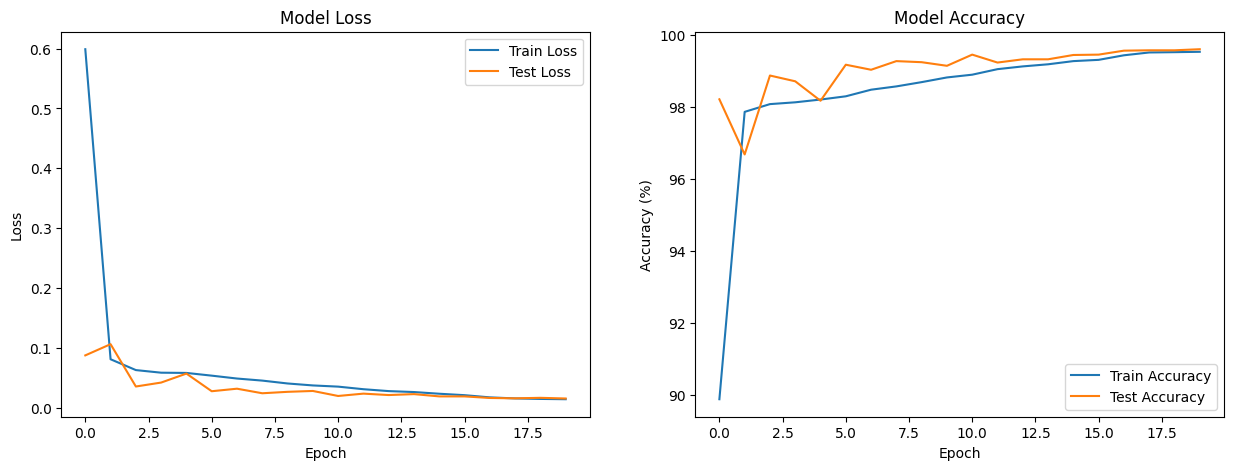

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(test_accuracies, label='Test Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.show()